In [ ]:
#---------------Shell Commands----------------------------------------------------------------------------------------------------------------------#

!pip uninstall -y gym gym-super-mario-bros                                                                                    
!pip install gym==0.26.2 gym-notices gym-super-mario-bros==7.4.0
!pip install stable-baselines3 gym_super_mario_bros nes_py
!pip install scipy 

In [9]:
#---------------Import necessary libraries---------------------------------------------------------------------------------------------------------#
import gym
import gym_super_mario_bros
from gym.wrappers import FrameStack, GrayScaleObservation
from gym.spaces import Box
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT

# Numerical computation and Deep Learning
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Helpers
import random
from collections import deque
import matplotlib.pyplot as plt
import torchvision.transforms as T
import time
import imageio
from PIL import Image
import re

In [10]:
#---------------Define Double Q Neural Network---------------------------------------------------------------------------------------------------------#

class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        # Compute the output size after convolutional layers
        def conv2d_size_out(size, kernel_size, stride):
            return (size - (kernel_size - 1) - 1) // stride + 1

        conv_h = conv2d_size_out(conv2d_size_out(conv2d_size_out(input_shape[1], 8, 4), 4, 2), 3, 1)
        conv_w = conv2d_size_out(conv2d_size_out(conv2d_size_out(input_shape[2], 8, 4), 4, 2), 3, 1)
        linear_input_size = conv_w * conv_h * 64

        self.fc1 = nn.Linear(linear_input_size, 512)
        self.fc2 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # flatten
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [11]:
#---------------Define Wrappers---------------------------------------------------------------------------------------------------------#

class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        for i in range(self._skip):
            obs, reward, done, truncated, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, truncated, info

class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation

class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape, antialias=True), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation

In [12]:
#---------------Configure environment---------------------------------------------------------------------------------------------------------#

env = gym_super_mario_bros.make('SuperMarioBrosRandomStages-v0', apply_api_compatibility=True, render_mode="none")
env = JoypadSpace(env, SIMPLE_MOVEMENT)  # Limit actions to simple movement

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Apply wrappers: frame skipping, grayscale, resizing, and stacking frames
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = FrameStack(env, num_stack=4)

# Hyperparameters
state_space = env.observation_space.shape  # (4, 84, 84)
action_space = env.action_space.n

# Initialize Q-networks (policy and target) for Dueling DDQN (or DDQN)
# policy_net = DuelingDQN((4, 84, 84), action_space).to(device)
# target_net = DuelingDQN((4, 84, 84), action_space).to(device)
policy_net = DQN((4, 84, 84), action_space).to(device)
target_net = DQN((4, 84, 84), action_space).to(device)
# target_net.load_state_dict(policy_net.state_dict())  # Synchronize networks
# target_net.eval()





In [13]:
#---------------Epsilon-greedy action selection---------------------------------------------------------------------------------------------------------#

def select_action(state, epsilon):
    if random.random() < epsilon:  # Explore
        return env.action_space.sample()
    else:  # Exploit (choose best action)
        with torch.no_grad():
            return policy_net(state).argmax().item()

# Create GIF from saved frames
def create_gif(frames, gif_path, fps=30):
    imageio.mimsave(gif_path, frames, fps=fps)

In [10]:
#---------------Load the trained model for testing---------------------------------------------------------------------------------------------------------#


model_path = 'policy_net_weights_8500.pth' 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#policy_net = DuelingDQN((4, 84, 84), action_space).to(device)
policy_net = DQN((4, 84, 84), action_space).to(device)
policy_net.load_state_dict(torch.load(model_path, map_location=device))
policy_net.eval()

# Initialize the Super Mario environment for testing
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0', apply_api_compatibility=True, render_mode="human")
#env = gym_super_mario_bros.make('SuperMarioBros-1-4-v0', apply_api_compatibility=True, render_mode="human")
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = FrameStack(env, num_stack=4)

# Preprocess the state for input to the model
def preprocess_state(state):
    state = np.ascontiguousarray(state)
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
    return state

# Helper function to extract Mario's position from the environment info
def get_mario_position(info):
    return info.get('x_pos', 0)  # Safely get x_pos, or 0 if not present

# Testing loop for multiple episodes
num_episodes = 1

for episode in range(num_episodes):
    state, info = env.reset()
    state = preprocess_state(state)
    done = False
    total_reward = 0
    x_pos_last = get_mario_position(info)
    standing_still_counter = 0  # Counter for standing still

    # Episode loop
    while not done:
        action = select_action(state, epsilon=0.00)  # Greedy action selection
        next_state, reward, terminated, truncated, next_info = env.step(action)
        next_state = preprocess_state(next_state)
        done = terminated or truncated

        # Get Mario's current position
        x_pos_current = get_mario_position(next_info)

        # If Mario's position hasn't changed increment stagnant counter
        if x_pos_current == x_pos_last:
            standing_still_counter += 1
        else:
            standing_still_counter = 0  # Reset

        # If Mario has stayed still for 30 steps terminate the episode
        if standing_still_counter >= 30:
            done = True
            print(f"Episode {episode + 1} ended due to standing still for 8 steps.")

        x_pos_last = x_pos_current  # Update last known position
        total_reward += reward
        state = next_state

    print(f"Episode {episode + 1}, Total Reward: {total_reward}")

env.close()


C:\Users\sfadm\AppData\Local\Temp\ipykernel_29432\356677886.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_net.load_state_dict(torch.load(model_path, map_locatio

Episode 1 ended due to standing still for 8 steps.
Episode 1, Total Reward: 2064.0


In [17]:
#---------Load GIFs---------------------------------------------------------------------------------------------------------#

model_path = 'policy_net_weights_20000.pth'
episode_number = re.search(r'\d+', model_path).group()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_net = DQN((4, 84, 84), action_space).to(device)
policy_net.load_state_dict(torch.load(model_path, map_location=device))
policy_net.eval()

# Initialize Mario environment
#env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0', apply_api_compatibility=True, render_mode="rgb_array")
env = gym_super_mario_bros.make('SuperMarioBros-1-4-v0', apply_api_compatibility=True, render_mode="rgb_array")
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = FrameStack(env, num_stack=4)

# Preprocess state for the model
def preprocess_state(state):
    state = np.ascontiguousarray(state)
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
    return state

# Helper function to extract Mario's position from the environment info
def get_mario_position(info):
    return info.get('x_pos', 0)  # Safely get x_pos, or 0 if not present

# List to store frames for GIF creation
frames = []

# Start an episode
state, _ = env.reset()
state = preprocess_state(state)
done = False
total_reward = 0

# Loop for recording episode frames
while not done:
    # Render and save the current frame
    img = env.render()
    img = Image.fromarray(img)
    img = img.resize((img.width * 4, img.height * 4), Image.NEAREST)  
    frames.append(np.array(img))

    # Select action using epsilon-greedy policy
    action = select_action(state, epsilon=0.00)
    next_state, reward, terminated, truncated, next_info = env.step(action)
    next_state = preprocess_state(next_state)
    done = terminated or truncated
    
    # Get Mario's current position
    x_pos_current = get_mario_position(next_info)

    # If Mario's position hasn't changed, increment stagnant counter
    # if x_pos_current == x_pos_last:
    #     standing_still_counter += 1
    # else:
    #     standing_still_counter = 0  # Reset if position changes

    # # If Mario has stayed still for 40 steps, terminate the episode
    # if standing_still_counter >= 40:
    #     done = True
    #     print(f"Episode {episode + 1} ended due to standing still for 40 steps.")

    total_reward += reward
    state = next_state

# Close environment after episode
env.close()

# Create GIF from saved frames
#imageio.mimsave('mario_episode_doubledqn_{episode_number}_11.gif', frames, fps=30)
gif_filename = f'mario_episode_doubledqn_{episode_number}_14.gif'
#gif_filename = f'mario_episode_doubledqn_{episode_number}_14.gif'
imageio.mimsave(gif_filename, frames, fps=15)
print(f"GIF successfully created and saved as {gif_filename}!")

C:\Users\sfadm\AppData\Local\Temp\ipykernel_28668\3272670118.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_net.load_state_dict(torch.load(model_path, map_locati

GIF successfully created and saved as mario_episode_doubledqn_20000_14.gif!


In [ ]:
#---------Data postprocessing---------------------------------------------------------------------------------------------------------#

# type: ignore

#------------------------------------------------------------------------------------------------------------------------------------#
# Step 1: Convert .txt file to CSV with ANSI encoding
#------------------------------------------------------------------------------------------------------------------------------------#

# Use PowerShell to convert the .txt file to a CSV file with ANSI encoding 
# from the console output during training:


# Episode: 0, Total Reward: 782.0, Epsilon: 1.0
# Replay Buffer Memory:  306
# Moving Average (Training):  782.0
# Episode: 1, Total Reward: 686.0, Epsilon: 0.9913970890487328
# Replay Buffer Memory:  594
# Moving Average (Training):  734.0
# Episode: 2, Total Reward: 625.0, Epsilon: 0.985377738013741
# Replay Buffer Memory:  797
# Moving Average (Training):  697.6666666666666
# Episode: 3, Total Reward: 625.0, Epsilon: 0.9810417250844651
# Replay Buffer Memory:  944
# Moving Average (Training):  679.5
# Episode: 4, Total Reward: 1075.0, Epsilon: 0.9673058958891547
# ...
# Episode: 14000, Total Reward: 2369.0, Epsilon: 0.02
# Replay Buffer Memory:  300000
# Moving Average (Training):  2521.22


# powershell
# Get-Content "C:\Users\sfadm\Desktop\DoubleDQN_11.txt" | ForEach-Object {
#     if ($_ -match 'Episode') {
#         $episode = ($_ -split ",")[0] -replace 'Episode: ', ''
#         $totalReward = ($_ -split ",")[1] -replace 'Total Reward: ', ''
#     }
#     elseif ($_ -match 'Moving Average') {
#         $movingAverage = ($_ -split ":")[1].Trim()
#         "$episode,$totalReward,$movingAverage" | Out-File "C:\Users\sfadm\Desktop\mario_data.csv" -Append -Encoding ASCII
#     }
# }

#------------------------------------------------------------------------------------------------------------------------------------#
# Step 2: Drop and recreate the table in DuckDB (or other)
#------------------------------------------------------------------------------------------------------------------------------------#

# Recreate the table in DuckDB to store the episode data
# This can be adapted to work with any SQL-based database system, like Postgres or SQLite.

# DROP TABLE IF EXISTS mario_data_ddqn_11;
# CREATE TABLE mario_data_ddqn_11 (
#     Episode INTEGER, 
#     Total_Reward DOUBLE, 
#     Moving_Average DOUBLE
# );

# DROP TABLE IF EXISTS mario_data_ddqn_14;
# CREATE TABLE mario_data_ddqn_14 (
#     Episode INTEGER, 
#     Total_Reward DOUBLE, 
#     Moving_Average DOUBLE,
#     Episode_Length INTEGER,
#     Step_Count    INTEGER,
#     Success       INTEGER
# );

#------------------------------------------------------------------------------------------------------------------------------------#
# Step 3: Import the data into the newly created table
#------------------------------------------------------------------------------------------------------------------------------------#

# SQL query to import data from the CSV into the database.
# For example, in DuckDB or another database, you can read and insert from CSV like this:

# INSERT INTO mario_data_ddqn_11
# SELECT * FROM read_csv_auto('C:/Users/sfadm/Desktop/mario_data.csv');

# INSERT INTO mario_data_ddqn_14
# SELECT * FROM read_csv_auto('C:/Users/sfadm/Desktop/training_log_double_14.txt', delim=',');

INSERT INTO mario_data_ddqn_14 
SELECT * FROM read_csv_auto('C:/Users/sfadm/Desktop/training_log_double_14_complete.txt', delim=','); 


# In case you had to abort the training


# WITH moving_avg_cte AS (
#     SELECT 
#         Episode,
#         AVG(Total_Reward) OVER (
#             ORDER BY Episode 
#             ROWS BETWEEN 99 PRECEDING AND CURRENT ROW
#         ) AS Moving_Average_New
#     FROM mario_data_ddqn_14
# )
# UPDATE mario_data_ddqn_14 t
# SET Moving_Average = m.Moving_Average_New
# FROM moving_avg_cte m
# WHERE t.Episode = m.Episode
# AND t.Moving_Average != m.Moving_Average_New;


#------------------------------------------------------------------------------------------------------------------------------------#
# Step 4: Remove duplicates from the table (sanity check)
#------------------------------------------------------------------------------------------------------------------------------------#

# SQL query to remove any duplicate episodes in the table
# The below query can be used in DuckDB or another SQL-based system.

# Note!: query performs a sanity check by removing duplicate episodes, ensuring 
# that only unique records remain in the table. It ensures data integrity 
# and maintains consistency across the dataset.

# DELETE FROM mario_data_ddqn_11
# WHERE Episode IN (
#     SELECT Episode
#     FROM mario_data_ddqn_11
#     GROUP BY Episode
#     HAVING COUNT(*) > 1
# )
# AND rowid NOT IN (
#     SELECT MIN(rowid)
#     FROM mario_data_ddqn_11
#     GROUP BY Episode
# );

DELETE FROM mario_data_ddqn_14 
WHERE Episode IN ( 
    SELECT Episode
    FROM mario_data_ddqn_14
    GROUP BY Episode
    HAVING COUNT(*) > 1
)
AND rowid NOT IN (
    SELECT MIN(rowid)
    FROM mario_data_ddqn_14
    GROUP BY Episode
);  

# Sanity check 
SELECT * FROM mario_data_ddqn_14;   

#------------------------------------------------------------------------------------------------------------------------------------#
# Step 5: Compute success rate per block of 500 episodes
#------------------------------------------------------------------------------------------------------------------------------------#

# SQL query to compute the success rate of episodes per block (500 or 1000 episodes each)
# This example works in DuckDB or any database that supports window functions.
# To successfully clear Level [1,1], a cumulative reward of at least 3000 points is required, while Level [1,4] demands a minimum of 2138 points.
# Also included, average episode length

# WITH Blocked_Episodes AS (
#     SELECT 
#         Episode,
#         Total_Reward,
#         FLOOR(Episode / 500) AS Block
#     FROM 
#         mario_data_ddqn_11
#        
# ),
# Success_Per_Block AS (
#     SELECT 
#         Block,
#         COUNT(CASE WHEN Total_Reward >= 3000 THEN 1 END) AS Successful_Episodes,
#         COUNT(*) AS Total_Episodes,
#         COUNT(CASE WHEN Total_Reward >= 3000 THEN 1 END) * 100.0 / COUNT(*) AS Success_Rate
#     FROM 
#         Blocked_Episodes
#     GROUP BY 
#         Block
# )

# SELECT 
#     Block * 500 AS Block_Start_Episode, 
#     Block * 500 + 499 AS Block_End_Episode,
#     Successful_Episodes, 
#     Total_Episodes, 
#     Success_Rate
# FROM 
#     Success_Per_Block
# ORDER BY 
#     Block;

# WITH Blocked_Episodes AS (
#     SELECT 
#         Episode,
#         FLOOR(Episode / 500) AS Block,
#         Success
#     FROM 
#         mario_data_ddqn_14
# ),
# Success_Per_Block AS (
#     SELECT 
#         Block,
#         SUM(Success) AS Successful_Episodes,
#         COUNT(*) AS Total_Episodes,
#         SUM(Success) * 100.0 / COUNT(*) AS Success_Rate
#     FROM 
#         Blocked_Episodes
#     GROUP BY 
#         Block
# )
# SELECT 
#     Block * 500 AS Block_Start_Episode, 
#     Block * 500 + 499 AS Block_End_Episode,
#     Successful_Episodes, 
#     Total_Episodes, 
#     Success_Rate
# FROM 
#     Success_Per_Block
# ORDER BY 
#  Block;

#------------------------------------------------------------------------------------------------------------------------------------#
# Step 5.5: Average episode length
#------------------------------------------------------------------------------------------------------------------------------------#

# A longer average episode length suggests that the agent is surviving longer in the environment, which often indicates better decision-making

# SELECT 
#     Block * 500 AS Block_Start_Episode, 
#     Block * 500 + 499 AS Block_End_Episode,
#     Successful_Episodes, 
#     Total_Episodes, 
#     Success_Rate
# FROM 
#     Success_Per_Block
# ORDER BY 
#     Block;

# WITH Blocked_Episodes AS (
#     SELECT 
#         Episode,
#         Episode_Length,
#         FLOOR(Episode / 500) AS Block
#     FROM 
#         mario_data_ddqn_14
# )
# SELECT 
#     Block * 500 AS Block_Start_Episode, 
#     Block * 500 + 499 AS Block_End_Episode,
#     AVG(Episode_Length) AS Average_Episode_Length
# FROM 
#     Blocked_Episodes
# GROUP BY 
#     Block
# ORDER BY 
#     Block;

# Or combine both:

WITH Blocked_Episodes AS (
    SELECT 
        Episode,
        Success,
        Episode_Length,
        FLOOR(Episode / 1000) AS Block
    FROM 
        mario_data_ddqn_14
),
Success_Per_Block AS (
    SELECT 
        Block,
        SUM(Success) AS Successful_Episodes,
        COUNT(*) AS Total_Episodes,
        SUM(Success) * 100.0 / COUNT(*) AS Success_Rate,
        AVG(Episode_Length) AS Average_Episode_Length
    FROM 
        Blocked_Episodes
    GROUP BY 
        Block
)
SELECT 
    Block * 1000 AS Block_Start_Episode, 
    Block * 1000 + 999 AS Block_End_Episode,
    Successful_Episodes, 
    Total_Episodes, 
    Success_Rate,
    Average_Episode_Length
FROM 
    Success_Per_Block
ORDER BY 
    Block;      






#------------------------------------------------------------------------------------------------------------------------------------#
# Step 6: Create the table with moving averages, and calculate min/max over the last 100 episodes for the Double DQN network
#------------------------------------------------------------------------------------------------------------------------------------#

# Create the table with moving averages, and calculate min/max over the last 100 episodes

COPY (WITH Moving_Avg_Window AS (
    SELECT 
        Episode, 
        Moving_Average,
        -- Define the window for the last 100 episodes
        MIN(Moving_Average) OVER (ORDER BY Episode ROWS BETWEEN 99 PRECEDING AND CURRENT ROW) AS min_moving_avg_100,
        MAX(Moving_Average) OVER (ORDER BY Episode ROWS BETWEEN 99 PRECEDING AND CURRENT ROW) AS max_moving_avg_100
    --FROM mario_data_ddqn_11
      FROM mario_data_ddqn_14
)
SELECT * FROM Moving_Avg_Window) 
--TO 'C:/Users/sfadm/Desktop/moving_avg_stats.csv' WITH (HEADER, DELIMITER ','); 
  TO 'C:/Users/sfadm/Desktop/moving_avg_stats_double_14.csv' WITH (HEADER, DELIMITER ','); 


#------------------------------------------------------------------------------------------------------------------------------------#
# Additional potential stats algorithm: Detect streaks of high rewards
#------------------------------------------------------------------------------------------------------------------------------------#

# SQL query to detect streaks of episodes where rewards are over a certain threshold (here 3040).
# This query can be run in DuckDB or other SQL-compliant databases.

# WITH episode_streaks AS (
#     SELECT
#         Episode,
#         Total_Reward,
#         CASE 
#             WHEN Total_Reward > 3040 THEN 1 
#             ELSE 0 
#         END AS reward_over_3000,
#         ROW_NUMBER() OVER (ORDER BY Episode) -
#         ROW_NUMBER() OVER (PARTITION BY CASE WHEN Total_Reward > 3040 THEN 1 ELSE 0 END ORDER BY Episode) AS streak_identifier
#     FROM
#         mario_data_ddqn_11
# ),
# streak_summary AS (
#     SELECT
#         MIN(Episode) AS episode_start,
#         MAX(Episode) AS episode_end,
#         COUNT(*) AS streak_length,
#         STRING_AGG(Total_Reward::TEXT, ',') AS total_reward_array
#     FROM
#         episode_streaks
#     WHERE
#         reward_over_3000 = 1
#     GROUP BY
#         streak_identifier
# )
# SELECT 
#     episode_start AS "Episode Start",
#     episode_end AS "Episode End",
#     streak_length AS "Streak Length",
#     total_reward_array AS "Total Reward Array"
# FROM
#     streak_summary
# ORDER BY
#     streak_length DESC;


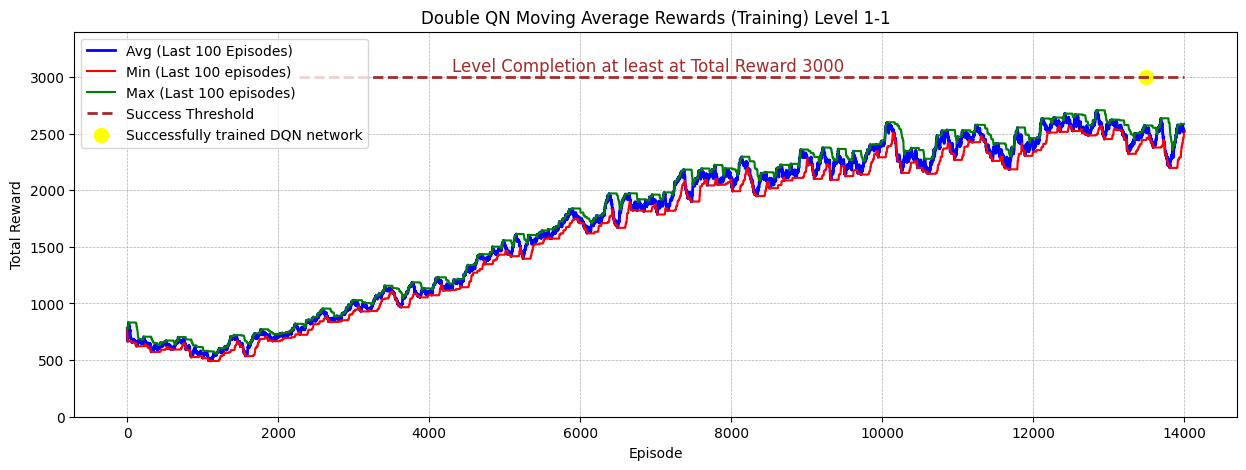

In [31]:
#-------Moving Averages [1,1]---------------------------------------------------------------------------------------------------------#

import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('moving_avg_stats_double.csv')
#df = pd.read_csv('moving_avg_stats_double_14.csv')

# Extract data for plotting
episode_numbers = df['Episode']
moving_average_training_smoothed = df['Moving_Average']
min_moving_average_training = df['min_moving_avg_100']
max_moving_average_training = df['max_moving_avg_100']

# Plot the result
plt.figure(figsize=(15, 5))

# Plot smoothed Training Moving Average with sliding min and max
plt.plot(episode_numbers, moving_average_training_smoothed, 'b-', label='Avg (Last 100 Episodes)', linewidth=2)
plt.plot(episode_numbers, min_moving_average_training, 'r-', linewidth=1.5, label='Min (Last 100 episodes)')
plt.plot(episode_numbers, max_moving_average_training, 'g-', linewidth=1.5, label='Max (Last 100 episodes)')

# Fill the area between min and max with lighter transparency
plt.fill_between(episode_numbers, min_moving_average_training, max_moving_average_training, facecolor='blue', alpha=0.07)

# Add a horizontal line at the success threshold (2138)
plt.plot([2280, episode_numbers.max()], [3000, 3000], color='brown', linestyle='--', linewidth=2, label='Success Threshold')
plt.text(4300, 3050, 'Level Completion at least at Total Reward 3000', color='brown', fontsize=12)
plt.ylim(0, 3400)

plt.scatter(13500, 3000, color='yellow', s=100, label='Successfully trained DQN network')

# Titles and labels
plt.title('Double QN Moving Average Rewards (Training) Level 1-1')
#plt.title('Double QN Moving Average Rewards (Training) Level 1-4')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend(loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('Double_DQN_reward_moving_avg_11.png', dpi=300)
#plt.savefig('Double_DQN_reward_moving_avg_14.png', dpi=300)

plt.show()


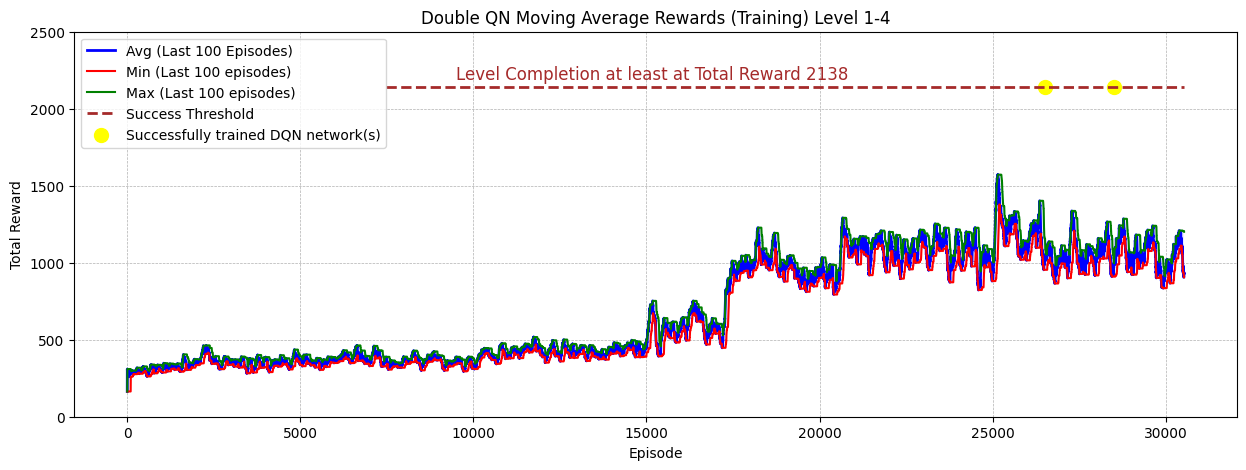

In [1]:
#-------Moving Averages [1,4]---------------------------------------------------------------------------------------------------------#

import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
#df = pd.read_csv('moving_avg_stats_double.csv')
df = pd.read_csv('moving_avg_stats_double_14.csv')

# Extract data for plotting
episode_numbers = df['Episode']
moving_average_training_smoothed = df['Moving_Average']
min_moving_average_training = df['min_moving_avg_100']
max_moving_average_training = df['max_moving_avg_100']

# Plot the result
plt.figure(figsize=(15, 5))

# Plot smoothed Training Moving Average with sliding min and max
plt.plot(episode_numbers, moving_average_training_smoothed, 'b-', label='Avg (Last 100 Episodes)', linewidth=2)
plt.plot(episode_numbers, min_moving_average_training, 'r-', linewidth=1.5, label='Min (Last 100 episodes)')
plt.plot(episode_numbers, max_moving_average_training, 'g-', linewidth=1.5, label='Max (Last 100 episodes)')

# Fill the area between min and max with lighter transparency
plt.fill_between(episode_numbers, min_moving_average_training, max_moving_average_training, facecolor='blue', alpha=0.07)

# Add a horizontal line at the success threshold (2138)
plt.plot([7480, episode_numbers.max()], [2138, 2138], color='brown', linestyle='--', linewidth=2, label='Success Threshold')
plt.text(9500, 2190, 'Level Completion at least at Total Reward 2138', color='brown', fontsize=12)
plt.ylim(0, 2500)

# Yellow point at episode 26,500 indicating success
plt.scatter(26500, 2138, color='yellow', s=100, label='Successfully trained DQN network(s)')
plt.scatter(28500, 2138, color='yellow', s=100)

# Titles and labels
#plt.title('Double QN Moving Average Rewards (Training) Level 1-1')
plt.title('Double QN Moving Average Rewards (Training) Level 1-4')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend(loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#plt.savefig('Double_DQN_reward_moving_avg_11.png', dpi=300)
plt.savefig('Double_DQN_reward_moving_avg_14.png', dpi=300)

plt.show()


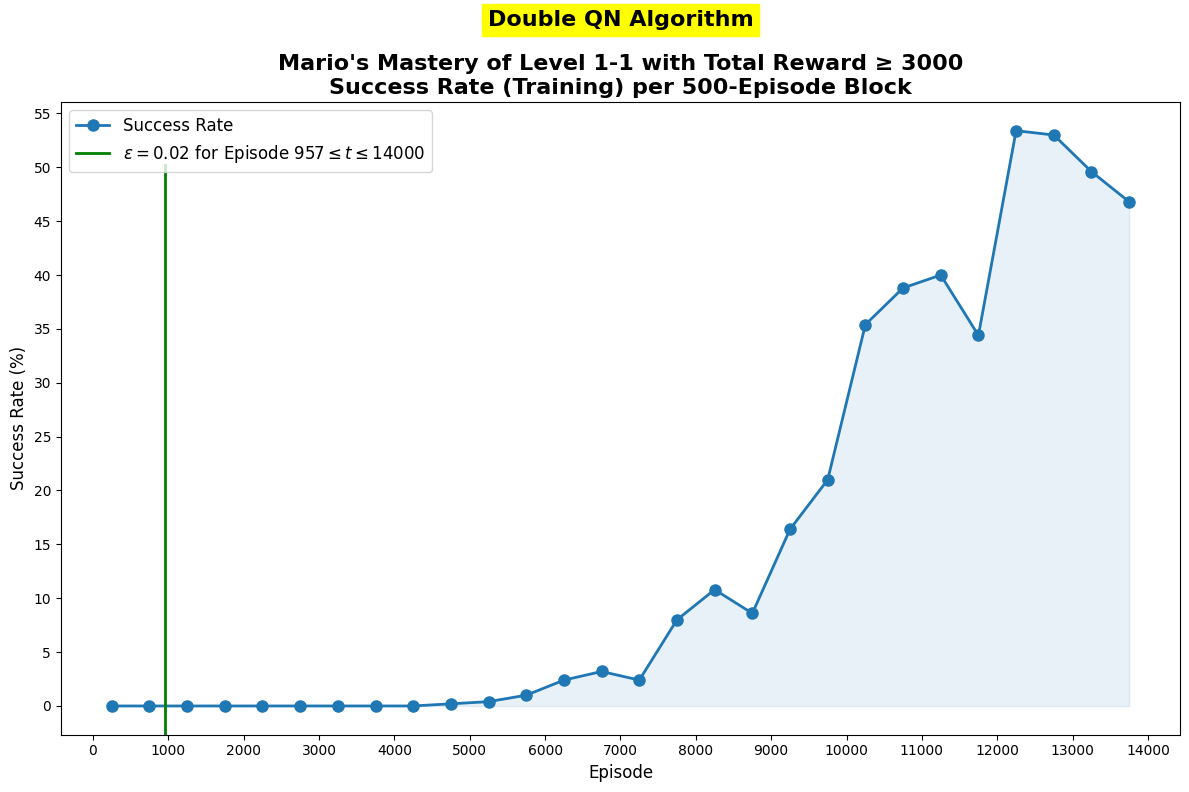

In [50]:
#-------------Success Rates v[1,1]---------------------------------------------------------------------------------------------------------#

import numpy as np
import matplotlib.pyplot as plt

mid_blocks = np.array([250, 750, 1250, 1750, 2250, 2750, 3250, 3750, 4250, 4750, 
                           5250, 5750, 6250, 6750, 7250, 7750, 8250, 8750, 9250, 9750, 
                           10250, 10750, 11250, 11750, 12250, 12750, 13250, 13750])
success_rates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 
                              0.4, 1.0, 2.4, 3.2, 2.4, 8.0, 10.8, 8.6, 16.4, 21.0, 
                              35.4, 38.8, 40.0, 34.4, 53.4, 53.0, 49.6, 46.8])

# Create a plot with the updated data
plt.figure(figsize=(12, 8))

# Plot the success rate with the updated data
plt.plot(mid_blocks, success_rates, marker='o', linestyle='-', color='#1f77b4', linewidth=2, markersize=8, label='Success Rate')

# Mark blocks and axes clearly
plt.fill_between(mid_blocks, success_rates, color='#1f77b4', alpha=0.1)

# Green line for Episode 957
plt.axvline(x=957, ymin=0, ymax=0.9, color='green', linestyle='-', linewidth=2, label=r'$\epsilon = 0.02 \ \mathrm{for} \ \mathrm{Episode} \ 957 \leq t \leq 14000$')

# Title with a three-line heading
plt.title("Mario's Mastery of Level 1-1 with Total Reward ≥ 3000\nSuccess Rate (Training) per 500-Episode Block", fontsize=16, fontweight='bold', loc='center', color='black')

# Highlight "Double DQN Algorithm" with a yellow box in the top line
highlight_text = "Double QN Algorithm"
plt.text(0.5, 1.12, highlight_text, fontsize=16, fontweight='bold', color='black', backgroundcolor='yellow', transform=plt.gca().transAxes, ha='center')

# X and Y axis labels
plt.xlabel("Episode", fontsize=12)
plt.ylabel("Success Rate (%)", fontsize=12)

# X-ticks: generally in 1000 steps
x_ticks = np.arange(0, 15000, 1000)
plt.xticks(x_ticks, fontsize=10)
plt.yticks(np.arange(0, 60, step=5), fontsize=10)

# Remove the grid
plt.grid(False)

# Adjust the legend and layout
plt.legend(fontsize=12, loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()


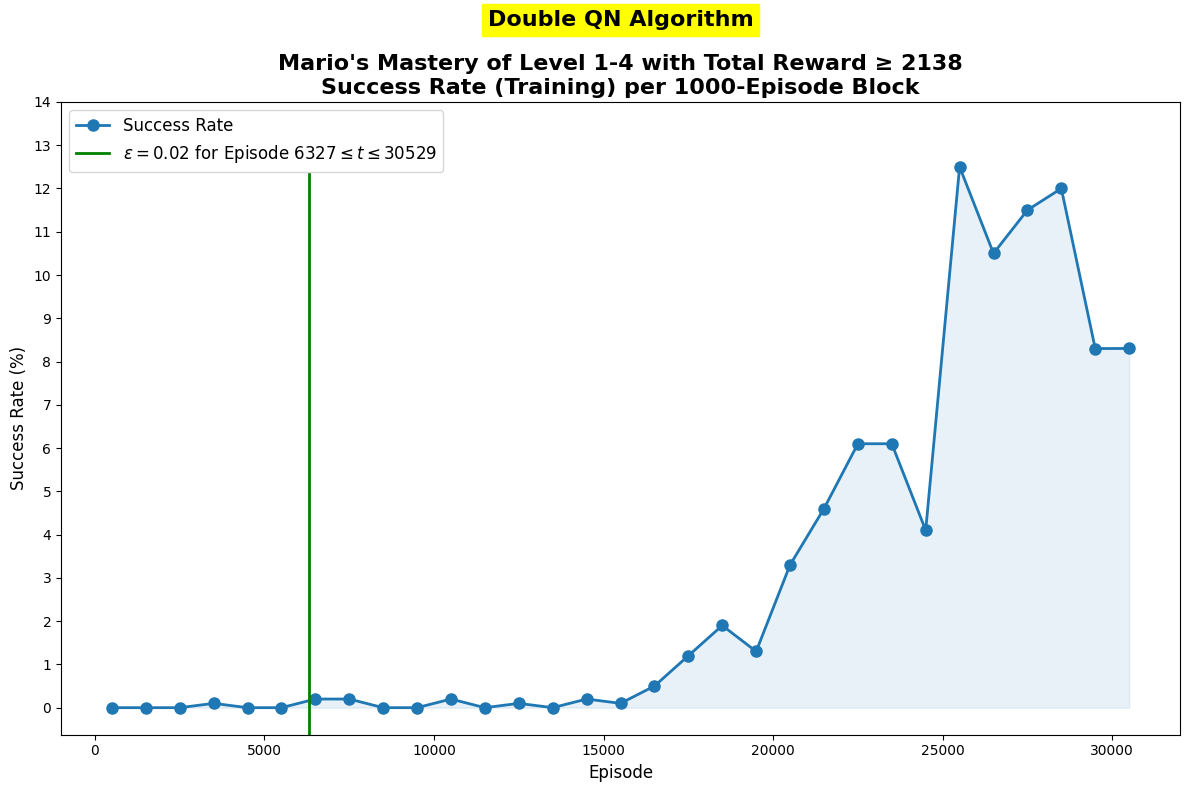

In [33]:
#-------------Success Rates v[1,4]---------------------------------------------------------------------------------------------------------#



mid_blocks = np.array([500, 1500, 2500, 3500, 4500, 5500, 6500, 7500, 8500, 9500, 
                               10500, 11500, 12500, 13500, 14500, 15500, 16500, 17500, 
                               18500, 19500, 20500, 21500, 22500, 23500, 24500, 25500, 
                               26500, 27500, 28500, 29500, 30500])
success_rates = np.array([0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.2, 0.2, 0.0, 0.0, 
                                  0.2, 0.0, 0.1, 0.0, 0.2, 0.1, 0.5, 1.2, 1.9, 1.3, 
                                  3.3, 4.6, 6.1, 6.1, 4.1, 12.5, 10.5, 11.5, 12.0, 8.3, 8.30188679245283])


plt.figure(figsize=(12, 8))
plt.plot(mid_blocks, success_rates, marker='o', linestyle='-', color='#1f77b4', linewidth=2, markersize=8, label='Success Rate')


plt.fill_between(mid_blocks, success_rates, color='#1f77b4', alpha=0.1)

# Green line for Episode 6327
plt.axvline(x=6327, ymin=0, ymax=0.886, color='green', linestyle='-', linewidth=2, label=r'$\epsilon = 0.02 \ \mathrm{for} \ \mathrm{Episode} \ 6327 \leq t \leq 30529$')

# Title with a three-line heading
plt.title("Mario's Mastery of Level 1-4 with Total Reward ≥ 2138\nSuccess Rate (Training) per 1000-Episode Block", fontsize=16, fontweight='bold', loc='center', color='black')

# Highlight "Double DQN Algorithm" with a yellow box in the top line
highlight_text = "Double QN Algorithm"
plt.text(0.5, 1.12, highlight_text, fontsize=16, fontweight='bold', color='black', backgroundcolor='yellow', transform=plt.gca().transAxes, ha='center')

# X and Y axis labels
plt.xlabel("Episode", fontsize=12)
plt.ylabel("Success Rate (%)", fontsize=12)

# X-ticks: generally in 5000 steps for visibility
x_ticks = np.arange(0, 31000, 5000)
plt.xticks(x_ticks, fontsize=10)
plt.yticks(np.arange(0, 15, step=1), fontsize=10)

# Remove the grid
plt.grid(False)

# Adjust the legend and layout
plt.legend(fontsize=12, loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

